# SPOTIFY DATA ANALYSIS

## 2. ENGAGEMENT

### Import libraries 

In [1]:
import os
import json
from pprint import pprint

import numpy as np
import pandas as pd

import datetime
import pytz

from scipy.stats import entropy

from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

### Load (previously cleaned) data 

The dataset the was previously extracted and formatted ([here](./prepare_data.ipynb)) consists of two different CSV files:
- **tracks.csv** containing all played tracks together with the useful metadata extracted from the raw Spotify JSON files. 
- **track_features.csv** contains the main audio features provided by Spotify for every track in tracks.csv without duplicates.

we merge those two files into one single dataframe containing all useful information. 

(N.B. This format is memory-expensive and not optimized, but the small size of the dataset allows it without any problem) 

In [2]:
tracks = pd.read_csv('../data/processed/tracks.csv', index_col=0)
features = pd.read_csv('../data/processed/track_features.csv', index_col=0)

data = pd.merge(tracks, features, on='id')
data.played_at = pd.to_datetime(data.played_at)
data.sort_values('played_at', inplace=True)
data.reset_index(inplace=True)
del data['index']

we add a column counting the time passed from the play of each track

In [3]:
data['time_from_last_play'] = datetime.datetime.now(datetime.timezone.utc) - data.played_at.dt.tz_convert(datetime.timezone.utc)

our dataset

In [4]:
data.head()

,played_at,name,duration_ms,id,popularity,artist,album,album_id,acousticness,danceability,...,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature,time_from_last_play
0,2019-08-05 12:20:25.523000+00:00,The Pheonix Flown,127986,5L8qzR3rsT9747tUeNGUBc,4,Steve Hackett,Beyond the Shrouded Horizon,3Ia0eMk5Eosw8JxZ5qS3kK,0.226,0.2950,...,0.866000,0.0962,-6.222,0.0510,77.898,0.159,9,1,4,509 days 03:16:59.372117
1,2019-08-05 12:21:09.612000+00:00,Wanderlust,44106,3TeTf7QjiNljQfH4IEiSrg,3,Steve Hackett,Beyond the Shrouded Horizon,3Ia0eMk5Eosw8JxZ5qS3kK,0.990,0.5470,...,0.972000,0.1120,-23.239,0.0791,95.002,0.264,0,1,3,509 days 03:16:15.283117
2,2019-08-05 12:23:50.676000+00:00,Til These Eyes,160933,4hT44AufFjOtPosMvHvRAR,5,Steve Hackett,Beyond the Shrouded Horizon,3Ia0eMk5Eosw8JxZ5qS3kK,0.762,0.2930,...,0.000179,0.1330,-11.543,0.0335,88.206,0.159,0,1,4,509 days 03:13:34.219117
3,2019-08-05 12:27:21.625000+00:00,Prairie Angel,178693,5ZiRwY5m25D15oEzPq5Y2U,4,Steve Hackett,Beyond the Shrouded Horizon,3Ia0eMk5Eosw8JxZ5qS3kK,0.120,0.0892,...,0.906000,0.3280,-8.198,0.0365,169.409,0.327,0,1,3,509 days 03:10:03.270117
4,2019-08-05 12:33:18.226000+00:00,A Place Called Freedom,356600,1wrRTfHIrmDy3mBVdYGTEF,4,Steve Hackett,Beyond the Shrouded Horizon,3Ia0eMk5Eosw8JxZ5qS3kK,0.660,0.2770,...,0.098300,0.2920,-7.654,0.0326,83.947,0.131,2,1,4,509 days 03:04:06.669117


### Feature engineering

The **engagement** dataframe will contain one row for each artist present in my data, and 3 columns that summarize nicely wether it's a one-time play, an artist that is recurrent and stable in my playlist, or if it was a temporary "crush" with an artist.

I use the following futures:
- time from the last play (in days)
- total number of times that artist was played
- the entropy of the daily count of times a song from a given artist was played

In [5]:
engagement = data.groupby(['artist']).time_from_last_play.min().to_frame()
engagement.time_from_last_play = engagement.time_from_last_play.apply(lambda x: x.days)
engagement['total_plays'] = data.groupby(['artist']).played_at.count()
engagement = engagement.reset_index()

In [6]:
daily_count = data.groupby(['artist', data.played_at.dt.date]).id.count()

daily_count_index = pd.date_range(data.played_at.dt.date.min(), 
                                  data.played_at.dt.date.max(), 
                                  freq='D')

daily_count = daily_count.unstack(level=0)
daily_count.reindex(daily_count_index)
daily_count.fillna(0., inplace=True)

In [7]:
ent = daily_count.apply(entropy)

engagement = engagement.set_index('artist')
engagement['entropy'] = ent
engagement.reset_index(inplace=True)

engagement.time_from_last_play = engagement.time_from_last_play + 1

In [8]:
engagement.head()

,artist,time_from_last_play,total_plays,entropy
0,...And You Will Know Us by the Trail of Dead,431,1,0.000000
1,369,187,3,1.098612
2,AC/DC,197,3,1.098612
3,ASMR Binaural Beats Library,213,1,0.000000
4,Abadá-Capoeira,292,1,0.000000


add a column useful for plotting

In [9]:
# point size in [1, 10]
size = 9*((engagement.entropy-engagement.entropy.min())/(engagement.entropy.max() - engagement.entropy.min()))+1
engagement.loc[:, 'size'] = size

### Plot results

first, a general overview of my daily use of Spotify. Since the Spotify APIs only keep the last 50 songs played, there are some holes in the data because I didn't save my data before running out of buffer. This is particularly evident in the second half of August, not because I wasn't using Spotify but because I wasn't running the script.

In [55]:
daily_count = daily_count.sum(axis=1)
daily_count.name = 'daily count'
daily_count = daily_count.reindex(daily_count_index).fillna(0.)

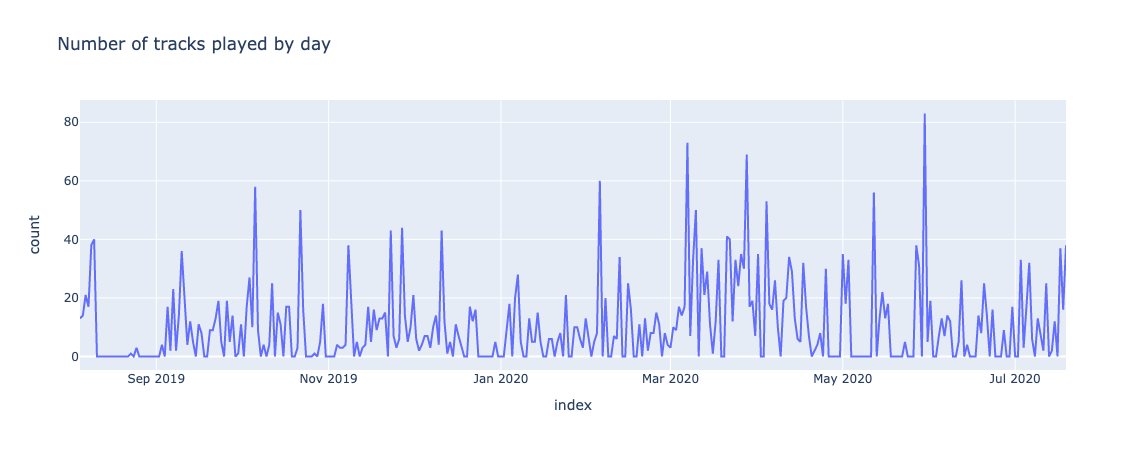

In [73]:
fig = px.line(
    daily_count, 
    labels={'played_at':'date', 'value':'count'}, 
    hover_data={'variable': False}, 
    hover_name='variable', 
    title='Number of tracks played by day'
)
fig.update_layout(showlegend=False)

It can be seen also looking at the previous plot, but with a cumulative visualization it is much clearer that exactly during the first lockdown in Italy (March-May) the slope of the curve increases, meaning that I was listening much more music during that period (even if it looks like it was reaching a plateau, perhaps I was saturated), and roughly going back to the "usual" slope after the lockdown ended.

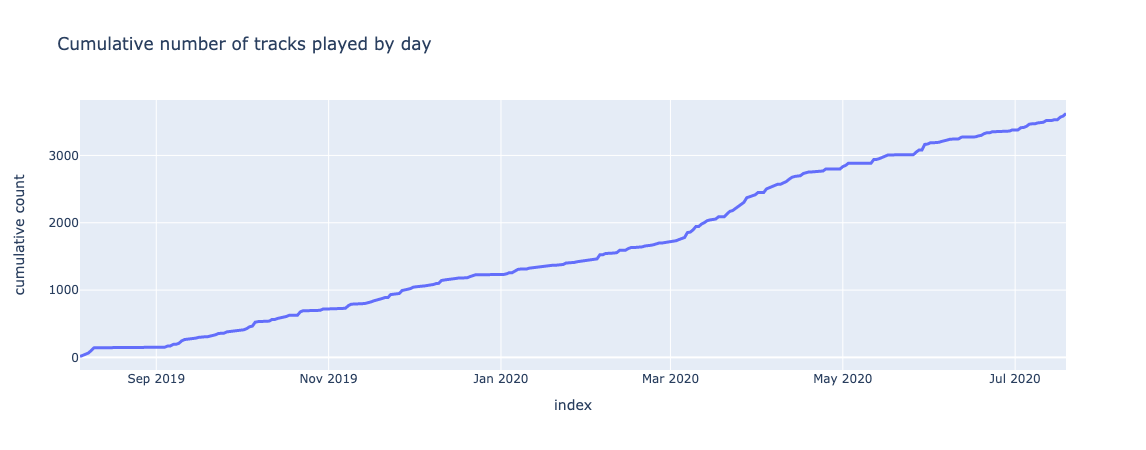

In [74]:
fig = px.line(
    daily_count.cumsum(), 
    labels={'played_at':'date', 'value':'cumulative count'}, 
    hover_data={'variable': False, 'value': False}, 
    hover_name='value', 
    title='Cumulative number of tracks played by day'
)
fig.update_traces(line=dict(width=3))
fig.update_layout(showlegend=False)

and now the main result of this short notebook, a scatter plot that shows the preference of the artists.

It can be read in this way: a high number of plays for a single artist is clearly a proxy of how much I like that artist, while the days since the last play tells if it's something that I'm listening right now of if it was more in the past. The size (the entropy) shows instead how "stable" an artist is in my playlist. High entropy roughly mean high recurrency in the playlist, low entropy means that it was played only few days (recent or past).

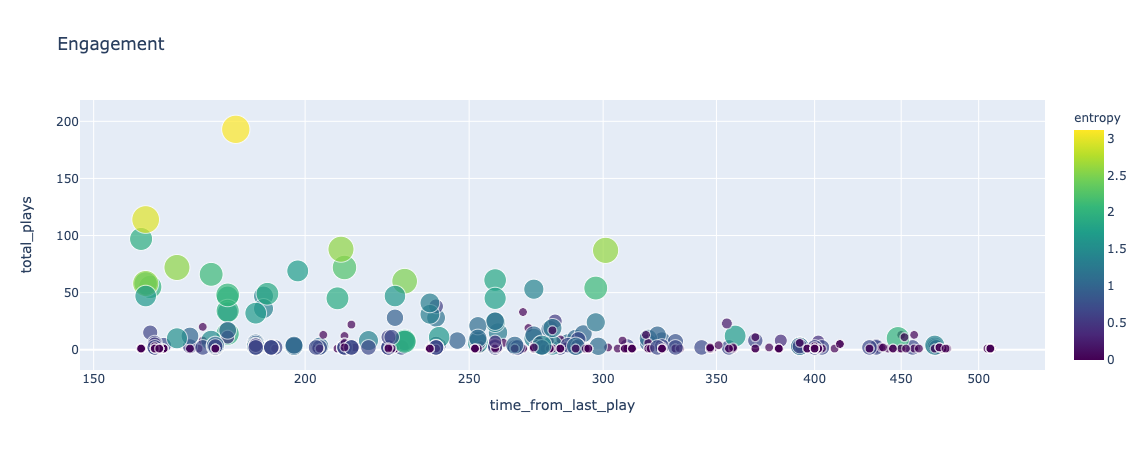

In [75]:
fig = px.scatter(
    engagement, 
    x="time_from_last_play", 
    y="total_plays", 
    color='entropy',
    size='size',
    hover_name="artist",
    hover_data={"size": False},
    color_continuous_scale='viridis',
    title='Engagement'
)

fig.update_layout(xaxis_type="log")
fig.show()